In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.constants as constants
import scipy.special as special

from qutip import *

#%matplotlib ipympl

# Max Fock State
N = 200

options = Options()
options.num_cpus = 5
options.nsteps = 100000

### Ideal Cubic Phase Gate

An ideal cubic phase gate takes the form 
$$
U_{\text{cube}} \equiv \exp{i \chi \hat{X}^3}
$$
where $\chi$ is the squeezing parameter.

We want to first study the Wigner function of the ideal cubic phase gate that we aspire to achieve.

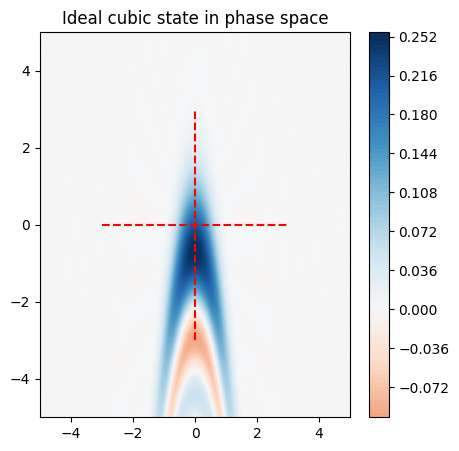

In [2]:
a = destroy(N)
x = ( 1/np.sqrt(2) ) * (a + a.dag())

chi = 1 # This is not the squeezing parameter, but just a convenient factor for simulation purposes.

H =  chi * x**3

psi0 = basis(N)  # Initialise in Fock |0> state.
t = [0.0, 1.0]

theory_output = mesolve(H = H, rho0 = psi0, tlist = t, options = options)
theory_rho = theory_output.states[-1]

xvec = np.linspace(-5, 5, 200)
theory_W = wigner(theory_rho, xvec, xvec)

# ---------- Plot Wigner Function at the end of the evolution ----------#
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

axes.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = axes.contourf(xvec, xvec, theory_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes.set_title("Ideal cubic state in phase space")
plt.colorbar(im)

### Filip Group: Pulse Sequence

The paper proposes the simulation of an ideal cubic phase gate via the following decomposition:
$$
    U_\text{cube} \approx U = \exp(i \gamma \hat{X}) \prod_{j=1}^N \bigg[\exp[i \phi_j \hat{\sigma}_y] \exp[it\hat{\sigma}_z \hat{X}] \bigg] \exp[i \phi_0 \hat{\sigma}_y]
$$
With better accuracies possible with a larger number of pulses, N.

In [3]:
solution = [-0.353282, 0.902028, -0.518804, 
            -0.447977, 0.447404, 0.231963,
            -0.307409, -0.191352, 0.354135,
            0.141061, -0.544457, -0.310069,
            0.685625, 0.623302, -0.144266,
            -0.808851, -0.102101, -0.682909,
            1.021610, 0.534188, -0.54781]

solution = [ 0.84673913,  0.19928457, -0.16676742, -0.35296603,  2.70355377,  2.70355586,
 -3.49455974,  2.97482611,  0.19928277,  0.84674023]
displacement = 4

def clean_plot(n_c, n_a, rho, tlist, size = 3, title = ''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(title, fontsize = 'xx-large', fontweight = 'bold')
    # ---------- Plot Wigner Function at the end of the evolution ----------#
    xvec = np.linspace(-size, size, 200)
    W = wigner(rho, xvec, xvec)

    axes[0].vlines(0, ymin = -size, ymax = size, colors = 'r', linestyles = 'dashed')
    axes[0].hlines(0, xmin = -size, xmax = size, colors = 'r', linestyles = 'dashed')
    im = axes[0].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    axes[0].set_title("Final State after N = 20 Pulses")
    plt.colorbar(im)

    # ---------- Plot atom & phonon population at end of evolution ----------#
    axes[1].plot(tlist, n_a, 'r-', label="Atom state")
    axes[1].plot(tlist, n_c, 'b-', label="Phonon state")
    axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[1].legend()
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Excitation probability")
    axes[1].set_title("Evolution of Spin")

In [4]:
a = tensor(qeye(2), destroy(N))
x = tensor(qeye(2), position(N))

sY = tensor(sigmay(), qeye(N))
sZ = tensor(sigmaz(), qeye(N))
sM = tensor(destroy(2), qeye(N))

psi0 = tensor(basis(2, 0), basis(N, 0))

def pulse(initial_state, angle):
    t_Spin = 1.0 # Spin interaction duration
    t_JC = 0.5 # Rabi interaction duration
    
    H1 = - angle * sY # Part 1
    H2 = - sZ * x    # Part 2

    t1 = np.linspace(0.0, t_Spin, 100)
    t2 = np.linspace(0.0, t_JC, 100)

    output = mesolve(H = H1, rho0 = initial_state, tlist = t1, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
    n_phonon = output.expect[0]
    n_atom_impt = output.expect[1]
    rho1 = output.states[-1]

    output = mesolve(H = H2, rho0 = rho1, tlist = t2, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
    n_phonon_impt = output.expect[0]
    n_atom = output.expect[1]
    rho2 = output.states[-1]
    
    return rho2, n_atom_impt, n_phonon_impt

In [5]:
psi = tensor(basis(2, 0), basis(N, 0))

states = [[] for i in range(len(solution))]
pop_atom = [[] for i in range(len(solution))]
pop_phonon = [[] for i in range(len(solution))]

for i in range(len(solution)):
    psi, n_atom, n_phonon = pulse(psi, solution[i])
    states[i] = psi
    pop_atom[i] = n_atom
    pop_phonon[i] = n_phonon

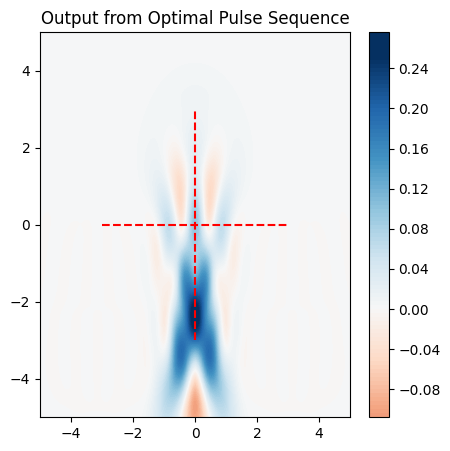

In [6]:
rho = states[-1]

H = displacement * x
t = np.linspace(0.0, 1.0, 100)

sequence_output = mesolve(H = H, rho0 = rho, tlist = t, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
sequence_n_phonon = sequence_output.expect[0]
sequence_n_atom = sequence_output.expect[1]
sequence_rho = sequence_output.states[-1]
sequence_rho = ptrace(sequence_rho, 1)

xvec = np.linspace(-5, 5, 200)
sequence_W = wigner(sequence_rho, xvec, xvec)

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

axes.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = axes.contourf(xvec, xvec, sequence_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes.set_title("Output from Optimal Pulse Sequence")
plt.colorbar(im)

### Trapped Ion Hamiltonian

We observe a potential problem with the method present by Filip's group shown above: the phononic states become highly populated. This leads to an issue specifically for the trapped ion scenario, where the high phonon-number states have spatially large wavefunctions, and therefore do not fall under the Lamb-Dicke approximation. Since the gate sequence suggested requires a JC-like Hamiltonian, this excitation beyond the Lamb-Dicke regime could cause big problems.

In this section, we simulate the same cubic phase gate, but using the full trapped ion Hamiltonian without the Lamb-Dicke approximation. This is done via the expansion of the Hamiltonian using the Zessenhaus formula to the 4th order, and via two laser beams detuned to the RSB and BSB mode frequencies to implement the displacement/position operation. This would verify whether the method suggested by Filip's group is implementable on a trapped ion set-up.

In [7]:
ld_param = 0.2
rabi_freq = 2/(ld_param * np.exp(-0.5 * ld_param**2))

def terms(order, rsb):
    j = order
    factor = (1j * ld_param) ** (2 * j)
    denom = math.factorial(j) * math.factorial(j + 1)

    if rsb == True:
        operator = sM.dag() * (a.dag()**j) * (a**(j + 1))
    elif rsb == False:
        operator = sM.dag() * (a.dag() ** (j + 1)) * (a**j)
    else:
        print("Operator is not well-defined")
        operator = tensor(qeye(2), qeye(N))

    return (factor / denom) * operator + (np.conjugate(factor) / denom) * operator.dag()

In [8]:
H_RSB = (rabi_freq/2) * np.exp(-0.5 * ld_param**2) * (-1j) * (1j * ld_param) * (terms(0, True) + terms(1, True) + terms(2, True))
H_BSB = (rabi_freq/2) * np.exp(-0.5 * ld_param**2) * (-1j) * (1j * ld_param) * (terms(0, False) + terms(1, False) + terms(2, False))

def pulse_ion(initial_state, angle):
    t_Spin = 1.0 # Spin interaction duration
    t_JC = 0.5 # Rabi interaction duration
    
    H1 = - angle * sY # Part 1
    H2 = - (H_RSB + H_BSB)

    t1 = [0.0, t_Spin]
    t2 = [0.0, t_JC]

    output = mesolve(H = H1, rho0 = initial_state, tlist = t1, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
    n_phonon = output.expect[0]
    n_atom_impt = output.expect[1]
    rho1 = output.states[-1]

    output = mesolve(H = H2, rho0 = rho1, tlist = t2, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
    n_phonon_impt = output.expect[0]
    n_atom = output.expect[1]
    rho2 = output.states[-1]
    
    return rho2, n_atom_impt, n_phonon_impt

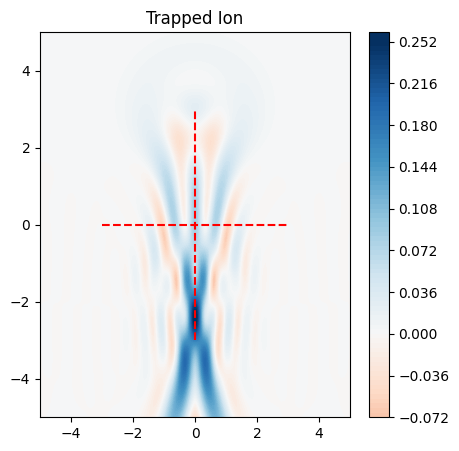

In [9]:
psi = tensor( (1 / np.sqrt(2)) * (basis(2, 0) + basis(2, 1)), basis(N, 0))

states = [[] for i in range(len(solution))]
pop_atom = [[] for i in range(len(solution))]
pop_phonon = [[] for i in range(len(solution))]

for i in range(0, len(solution)):
    psi, n_atom, n_phonon = pulse_ion(psi, solution[i])
    states[i] = psi
    pop_atom[i] = n_atom
    pop_phonon[i] = n_phonon

rho = states[-1]

H = displacement * x
t = np.linspace(0.0, 1.0, 100)

output = mesolve(H = H, rho0 = rho, tlist = t, e_ops = [a.dag() * a, sM.dag() * sM], options = options)
n_phonon = output.expect[0]
n_atom = output.expect[1]
exp_rho = output.states[-1]
exp_rho = ptrace(exp_rho, 1)

xvec = np.linspace(-5, 5, 200)
exp_W = wigner(exp_rho, xvec, xvec)

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

axes.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
axes.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = axes.contourf(xvec, xvec, exp_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
axes.set_title("Trapped Ion")
plt.colorbar(im)


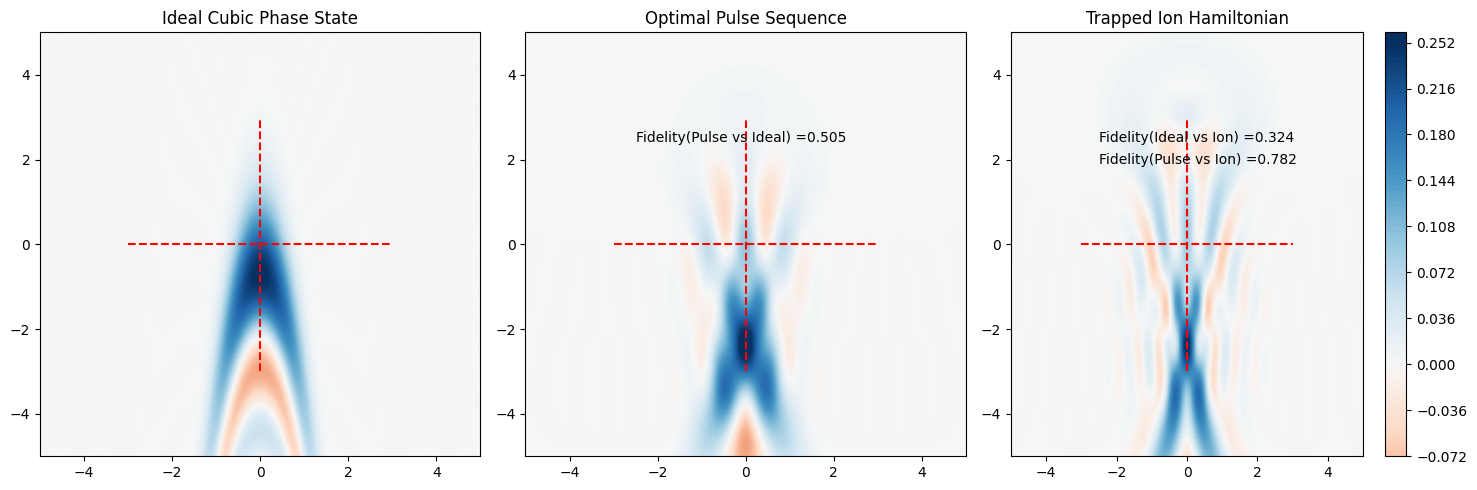

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
ax[0].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = ax[0].contourf(xvec, xvec, theory_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax[0].set_title("Ideal Cubic Phase State")

ax[1].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
ax[1].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = ax[1].contourf(xvec, xvec, sequence_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax[1].set_title("Optimal Pulse Sequence")
ax[1].text(-2.5, 2.5, "Fidelity(Pulse vs Ideal) =" + str(np.round(fidelity(sequence_rho, theory_rho), 3)), verticalalignment='center')

ax[2].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
ax[2].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
im = ax[2].contourf(xvec, xvec, exp_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax[2].set_title("Trapped Ion Hamiltonian")
ax[2].text(-2.5, 2.5, "Fidelity(Ideal vs Ion) =" + str(np.round(fidelity(exp_rho, theory_rho), 3)), verticalalignment='center')
ax[2].text(-2.5, 2.0, "Fidelity(Pulse vs Ion) =" + str(np.round(fidelity(exp_rho, sequence_rho), 3)), verticalalignment='center')

plt.colorbar(im)
plt.tight_layout()